#### Sociology 128D: Mining Culture Through Text Data: Introduction to Social Data Science

# Notebook 8: Bias and Stereotyping in Pretrained Word Embeddings

In this notebook, we will use pretrained word embeddings to develop intuitions about how word embedding models can be used to answer social research questions. We start with a brief introduction to word embeddings in general and a demonstration of solving analogies using word vectors.

Next, we draw inspiration from ["The Geometry of Culture" (Kozlowski, Taddy, & Evans, 2019)](https://journals.sagepub.com/doi/full/10.1177/0003122419877135) and explore how word embedding models can be used to study cultural associations, for example classed, racialized, and gendered perceptions of music.

## What are Word Embeddings?

Word embeddings are vectors (lists of numbers) that represent the positions of distinct words in a shared embedding space. They are similar to the tf-idf-weighted document vectors we used in [Notebook 5](https://soc128d.github.io/notebooks/) in that the unit of analysis is represented by a vector of numbers and these numbers reflect information about the co-occurrence of words in a corpus. In this case, however, the unit of analysis is the individual word, not a document.

In general, word embeddings capture patterns of similar usage of words. Words used in similar contexts will be closer together in the embedding space. Synonyms are the extreme case: if you replace one synonym with another in a sentence (e.g., replace "car" with "automobile"), the meaning of the sentence may not change a great deal. Both synonyms could reasonably be used in that sentence, and both versions of that sentence (or sentences like it) could occur frequently in a corpus. The other words in the sentence are <tt>context words</tt> (and, in fact, every word is a context word for every other word in a given sentence). Words used frequently in the presence of the same context words appear closer together in the embedding space.

In Notebook 5, we started with a document X term (word) matrix. For word embeddings, the inuitive starting point is a word X _context word_ matrix representing the number of times words co-occur (or are "context words" for one another). The issue is that such a matrix is often very sparse: it might be very large, but most words do not co-occur. Other approaches lead to dense vectors in which columns do not correspond to context words.

We can use measures like cosine similarity to quantify the distance in the embedding space, and this reflects similarity in how words are used. We often make the further leap of assuming that this measures what words _mean_. [Sahlgren (2008, p. 1)](https://www.diva-portal.org/smash/get/diva2:1041938/FULLTEXT01.pdf) points to numerous formulations of this claim:

> Distributional approaches to meaning acquisition utilize distributional properties of linguistic entities as the building blocks of semantics. In doing so, they rely fundamentally on a set of assumptions about the nature of language and meaning referred to as the distributional hypothesis. This hypothesis is often stated in terms like “words which are similar in meaning occur in similar contexts” (Rubenstein & Goodenough, 1965); “words with similar meanings will occur with similar neighbors if enough text material is available” (Sch ̈utze & Pedersen, 1995); “a representation that captures much of how words are used in natural context will capture much of what we mean by meaning” (Landauer & Dumais, 1997); and “words that occur in the same contexts tend to have similar meanings” (Pantel, 2005), just to quote a few representative examples. The general idea behind the distributional hypothesis seems clear enough: there is a correlation between distributional similarity and meaning similarity, which allows us to utilize the former in order to estimate the latter.

There are a number of approaches to training word embeddings, but one of the most common--as we've seen in various readings--is word2vec. You can find an excellent illustrated guide to word2vec [here](https://jalammar.github.io/illustrated-word2vec/).

## Setup

You'll need a version of the `gensim` library. You can install `gensim` from the Anaconda interpreter using the following command:

```
conda install -c anaconda gensim
```

If you are not using Anaconda, you can use `pip` to install `gensim` from the command line:

```
pip3 install gensim
```

This notebook has been tested with versions 3.8.3 and 4.0.1. In the shift to version 4, [a few notable changes were made](https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4). For this notebook, the only difference that should matter is that word embedding models had a <tt>.vocab</tt> attribute in version 3, and this has been replaced with <tt>.key_to_index</tt> in version 4. There are a couple of lines of code in this notebook that use one of these attributes; they are flagged for you, and you can simply make sure to comment out the version you don't need and uncomment the version you do.

Later in the notebook, you'll explore latent cultural dimensions measured as in ["The Geometry of Culture"](https://journals.sagepub.com/doi/full/10.1177/0003122419877135). You will create these using pairs of antonyms provided by the authors. The notebook includes links to these lists of word pairs and a function to load them as well as a function that will get them directly from the web. If you plan to use the word pairs on your own (e.g., for your project) or plan to run the notebook multiple times, it might be best to download the lists and use the function provided to load them. Otherwise, getting them directly from the web should be fine.

In [33]:
import gensim.downloader
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import requests

from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

sns.set_theme(style="darkgrid")

`sklearn`'s `cosine_similarity()` method expects vectors to be in a certain shape. The <tt>cosine_reshape()</tt> function below is a helper function to handle that for us.

In [2]:
def cosine_reshape(vec1, vec2):
    """
    Reshape word vectors and return cosine
    similarity
    """
    if vec1.shape[0] > 1:
        vec1 = vec1.reshape(1, -1)
    if vec2.shape[0] > 1:
        vec2 = vec2.reshape(1, -1)
    assert vec1.shape == vec2.shape
    return cosine_similarity(vec1, vec2)[0][0]

Let's load our word embedding model. The notebook defaults to [<tt>word2vec-google-news-300</tt>](https://github.com/RaRe-Technologies/gensim-data), which has a vocabulary of three million words, has three hundred dimensions, and was trained on a Google New corpus. You can try other pretrained embeddings if you prefer. `gensim` also vectors trained using algorithms like [GloVe](https://nlp.stanford.edu/projects/glove/), with versions trained on different types of data and with different numbers of dimensions. Typically, smaller models (i.e., with smaller vocabularies or fewer dimensions) are faster to work with, but may not represent the meaning of the words as well.

<b>Note: If you are using a particular model for the first time, the following cell will try to print a progress bar for the download, and you may get repeated warnings. It should continue to run despite these warnings. Once it has downloaded, you can run the cell again, or even comment it out, to hide the output.<br>

In [3]:
# word_vectors = gensim.downloader.load("glove-wiki-gigaword-300") # if you'd prefer to try GloVe vectors instead!
word_vectors = gensim.downloader.load("word2vec-google-news-300")

In [6]:
type(word_vectors)

gensim.models.keyedvectors.KeyedVectors

#### If you have `gensim` 4.0, you'll need to comment out the lines with references to the <tt>.vocab</tt> attribute and uncomment the lines that reference to the <tt>.key_to_index</tt> attribute.

In [7]:
type(word_vectors.key_to_index)
# type(word_vectors.vocab)

dict

In [8]:
print(f"There are {len(word_vectors.key_to_index):,} words in the vocabulary.")
# print(f"There are {len(word_vectors.vocab):,} words in the vocabulary.")

There are 3,000,000 words in the vocabulary.


Let's take a look at an example of a word embedding.

In [9]:
word_vectors["sociology"]

array([ 3.55468750e-01,  4.15039062e-02, -6.83593750e-03,  3.90625000e-01,
        2.44140625e-01,  1.21459961e-02,  2.57812500e-01, -1.96289062e-01,
       -4.39453125e-02, -1.77734375e-01,  2.81250000e-01, -7.56835938e-02,
       -4.83398438e-02,  2.41210938e-01, -2.57812500e-01,  6.44531250e-02,
        2.50000000e-01,  2.94189453e-02,  1.25976562e-01, -3.94531250e-01,
        1.12792969e-01,  1.51367188e-01,  6.15234375e-02, -3.88671875e-01,
        8.25195312e-02, -3.22265625e-01, -2.17773438e-01,  1.07421875e-01,
       -9.17968750e-02,  7.03125000e-02,  5.20019531e-02,  1.89453125e-01,
        2.49023438e-02, -1.22558594e-01, -1.62109375e-01, -2.07519531e-02,
        2.15820312e-01,  2.69531250e-01, -2.41699219e-02,  1.01562500e-01,
       -1.27929688e-01, -2.25830078e-03, -1.37695312e-01,  2.36328125e-01,
       -1.66015625e-01,  8.49609375e-02,  1.98974609e-02, -1.08398438e-01,
        1.58203125e-01,  4.00390625e-01, -1.00097656e-01,  4.69207764e-04,
        1.25976562e-01, -

The embedding for sociology indicates its position in a 300-dimensional space, but there is a vocabulary of three million words. The dimensions do not correspond to context words, and do not necessarily correspond to anything interpretable on their own.

In [10]:
len(word_vectors["sociology"])

300

## Similarity and Analogies

`gensim` makes it easy to compare word embeddings. the `.similarity()` method takes two words as arguments and provides the cosine similarity of the word embeddings. This is the same measure of similarity we used for comparing document vectors.

`gensim`'s `.most_similar()` method takes one word as an argument and provides the <tt>topn</tt> most similar words in the model. However, the `.most_similar()` method also allows you to add and subtract word vectors.

In [11]:
word_vectors.similarity("sociology", "anthropology")

0.76546633

In [12]:
word_vectors.most_similar("sociology", topn=10)

[('anthropology', 0.7654664516448975),
 ('criminology', 0.7448034882545471),
 ('Sociology', 0.743191659450531),
 ('psychology', 0.7200210094451904),
 ('sociology_anthropology', 0.710257351398468),
 ('comparative_literature', 0.6931983828544617),
 ('Political_Science', 0.6850624084472656),
 ('anthropology_sociology', 0.6627179980278015),
 ('Africana_studies', 0.6604623794555664),
 ('sociology_criminology', 0.6589326858520508)]

The typical example of analogies with word vectors is finding a feminine counterpart of "king" by addition and subtraction of other vectors. Starting with the vector for king, we can subtract the vector for "man" and add the vector for "woman."

The analogy takes the following form:
```
 man:king::woman:___
```
Using the `.most_similar()` method, we provide a `list` called <tt>positive</tt> that includes "king" and "woman" and a `list` called <tt>negative</tt> including only "man." You can think of this as adding the vector for "woman" to the vector for "king" while subtracting the vector for "man."

In [13]:
word_vectors.most_similar(positive=["king", "woman"], negative=["man"], topn=10)

[('queen', 0.7118193507194519),
 ('monarch', 0.6189674139022827),
 ('princess', 0.5902431011199951),
 ('crown_prince', 0.5499460697174072),
 ('prince', 0.5377321839332581),
 ('kings', 0.5236844420433044),
 ('Queen_Consort', 0.5235945582389832),
 ('queens', 0.5181134343147278),
 ('sultan', 0.5098593831062317),
 ('monarchy', 0.5087411999702454)]

Word vectors can also seemingly pick up aspects of grammar:

```
wide:wider::light:___
read:reading::listen:___
write:wrote::listen:___
```

In [14]:
word_vectors.most_similar(positive=["wider", "light"], negative=["wide"], topn=1)

[('lighter', 0.4419083893299103)]

In [15]:
word_vectors.most_similar(positive=["reading", "listen"], negative=["read"], topn=1)

[('listening', 0.7428543567657471)]

In [16]:
word_vectors.most_similar(positive=["wrote", "listen"], negative=["write"], topn=1)

[('listened', 0.5621737241744995)]

What about when we subtract the vector for "society" from the vector for "sociology" and add the vector for "cell"?

```
society:sociology::cell:___
```

In [17]:
word_vectors.most_similar(positive=["sociology", "cell"], negative=["society"], topn=10)

[('biochemistry', 0.48492422699928284),
 ('biological_anthropology', 0.4392480254173279),
 ('molecular_physiology', 0.4315635561943054),
 ('integrative_physiology', 0.430625319480896),
 ('molecular_pharmacology', 0.42511114478111267),
 ('electrical_engineering', 0.41834139823913574),
 ('molecular_biology_biochemistry', 0.41195404529571533),
 ('biology', 0.4115855395793915),
 ('criminology', 0.4100933372974396),
 ('biochemistry_molecular_biology', 0.40700894594192505)]

## Measuring "Cultural Dimensions"

#### If you would prefer to download and save the lists of word pairs used by Kozlowski et al. (2019):

Affluence pairs: https://raw.githubusercontent.com/KnowledgeLab/GeometryofCulture/master/code/word_pairs/affluence_pairs.csv

Gender pairs: https://raw.githubusercontent.com/KnowledgeLab/GeometryofCulture/master/code/word_pairs/gender_pairs.csv

Race pairs: https://raw.githubusercontent.com/KnowledgeLab/GeometryofCulture/master/code/word_pairs/race_pairs.csv

In [18]:
def read_pairs_from_file(f: str) -> list:
    """
    Read in word pairs from `f` as list
    """
    
    pairs = open(f, "r").read().strip().split("\n")
    pairs = [pair.split(",") for pair in pairs]
    return [(pair[0], pair[1]) for pair in pairs]

In [19]:
aff_f = "affluence_pairs.csv"
gender_f = "gender_pairs.csv"
race_f = "race_pairs.csv"

aff_pairs = read_pairs_from_file(aff_f)
gender_pairs = read_pairs_from_file(gender_f)
race_pairs = read_pairs_from_file(race_f)

#### If you would prefer to get the lists of word pairs used by Kozlowski et al. (2019) using the `requests` library:

In [20]:
def read_pairs_from_url(url: str) -> list:
    """
    Get word pairs using requests library
    """
    
    pairs = requests.get(url)
    pairs = pairs.text.strip().split("\n")
    pairs = [pair.replace("\r", "").split(",") for pair in pairs]
    return [(pair[0], pair[1]) for pair in pairs]

In [21]:
aff_url = "https://raw.githubusercontent.com/KnowledgeLab/GeometryofCulture/master/code/word_pairs/affluence_pairs.csv"
gender_url = "https://raw.githubusercontent.com/KnowledgeLab/GeometryofCulture/master/code/word_pairs/gender_pairs.csv"
race_url = "https://raw.githubusercontent.com/KnowledgeLab/GeometryofCulture/master/code/word_pairs/race_pairs.csv"

aff_pairs = read_pairs_from_url(aff_url)
gender_pairs = read_pairs_from_url(gender_url)
race_pairs = read_pairs_from_url(race_url)

In [22]:
aff_pairs

[('rich', 'poor'),
 ('richer', 'poorer'),
 ('richest', 'poorest'),
 ('affluence', 'poverty'),
 ('advantaged', 'disadvantaged'),
 ('affluent', 'destitute'),
 ('classy', 'beggarly'),
 ('costly', 'economical'),
 ('exorbitant', 'impecunious'),
 ('expensive', 'inexpensive'),
 ('exquisite', 'ruined'),
 ('extravagant', 'necessitous'),
 ('flush', 'skint'),
 ('invaluable', 'cheap'),
 ('lavish', 'economical'),
 ('luxuriant', 'penurious'),
 ('luxurious', 'threadbare'),
 ('luxury', 'cheap'),
 ('moneyed', 'unmonied'),
 ('opulent', 'indigent'),
 ('plush', 'threadbare'),
 ('posh', 'plain'),
 ('precious', 'cheap'),
 ('priceless', 'worthless'),
 ('privileged', 'underprivileged'),
 ('propertied', 'bankrupt'),
 ('prosperous', 'unprosperous'),
 ('developed', 'underdeveloped'),
 ('solvency', 'insolvency'),
 ('successful', 'unsuccessful'),
 ('sumptuous', 'plain'),
 ('swanky', 'basic'),
 ('opulent', 'needy'),
 ('upscale', 'squalid'),
 ('valuable', 'valueless'),
 ('wealthy', 'impoverished'),
 ('ritzy', 'ramsh

In [23]:
gender_pairs

[('man', 'woman'),
 ('men', 'women'),
 ('he', 'she'),
 ('him', 'her'),
 ('his', 'her'),
 ('his', 'hers'),
 ('boy', 'girl'),
 ('boys', 'girls'),
 ('male', 'female'),
 ('masculine', 'feminine')]

In [24]:
race_pairs

[('black', 'white'),
 ('blacks', 'whites'),
 ('African', 'caucasian'),
 ('African', 'European'),
 ('Afro', 'Anglo'),
 ('Black', 'White'),
 ('Blacks', 'Whites')]

The function below is a recreation of the <tt>make_dim()</tt> function in the original `R` code provided by Kozlowski et al. [here](https://github.com/KnowledgeLab/GeometryofCulture/blob/master/code/build_cultural_dimensions.R). Like other research on bias in word embeddings, this work presupposes cultural associations that can be represented as binaries or continua.

To identify an "affluence" dimension, this approach uses the differences of vectors for antonyms like "rich" and "poor" (e.g., "rich" minus "poor").

To identify "gender" and "race" dimensions, this approach makes the assumption that _culturally_ there are axes where the idea of gender or ethnic "antonyms" makes sense. If there is gender bias such that some things are stereotyped as being more associated with men than women (or vice versa), this approach may be able to detect it.

In [25]:
def make_dim(word_pairs: list) -> np.ndarray:
    """
    Calculate a "cultural dimension" as in
    https://github.com/KnowledgeLab/GeometryofCulture/blob/master/code/build_cultural_dimensions.R
    """
    
    diffs = []
    
    for pair in word_pairs:
        
        word1, word2 = pair
        
        if word1 in word_vectors and word2 in word_vectors:

            vec1 = word_vectors[pair[0]]
            vec1 = vec1/np.linalg.norm(vec1) # norm the first word vector

            vec2 = word_vectors[pair[1]]
            vec2 = vec2/np.linalg.norm(vec2) # norm the second second vector

            diff = vec1 - vec2
            diff = diff/np.linalg.norm(diff) # norm the difference between the vectors
            diffs.append(diff)               # append the difference to the list
            
        else:
            print(f"Missing: {pair}") # missing words from affluence pairs
        
    dim = np.mean(diffs, axis=0) # average the vectors appended to the list
    dim = dim/np.linalg.norm(dim) # norm the average
    
    return dim

Now we can calculate the cultural dimensions!

In [26]:
aff_dim = make_dim(aff_pairs)
gender_dim = make_dim(gender_pairs)
race_dim = make_dim(race_pairs)

Missing: ('moneyed', 'unmonied')
Missing: ('prosperous', 'unprosperous')


Each is a 300-dimensional vector just like the word vectors, but it doesn't correspond to a single word.

In [27]:
type(aff_dim)

numpy.ndarray

In [28]:
aff_dim.shape

(300,)

#### Locating musical genres along these dimensions

Now we can create a plot like Figure 3 in the original paper (p. 921). We won't overlay a plot based on survey data.

In [29]:
genres = ["jazz", "rap", "opera", "punk", "techno", "hiphop", "bluegrass"]

In [30]:
aff_proj_dict = {}
gender_proj_dict = {}
race_proj_dict = {}

for genre in genres:
    cos_aff = cosine_reshape(word_vectors[genre], aff_dim)
    aff_proj_dict[genre] = cos_aff
    
    cos_gender = cosine_reshape(word_vectors[genre], gender_dim)
    gender_proj_dict[genre] = cos_gender
    
    cos_race = cosine_reshape(word_vectors[genre], race_dim)
    race_proj_dict[genre] = cos_race

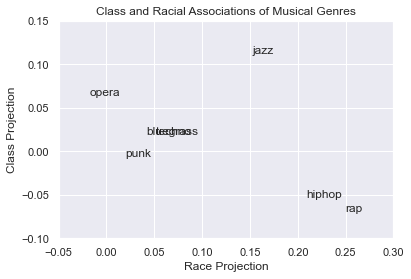

In [31]:
for genre in genres:
    plt.text(x=race_proj_dict[genre], y=aff_proj_dict[genre], s=genre)
    
plt.xlim(-0.05,0.3)
plt.ylim(-0.10, 0.15)

plt.xlabel("Race Projection")
plt.ylabel("Class Projection")
plt.title("Class and Racial Associations of Musical Genres")
plt.show()

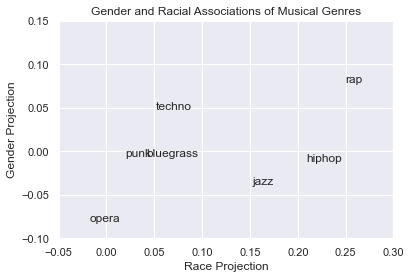

In [32]:
for genre in genres:
    plt.text(x=race_proj_dict[genre], y=gender_proj_dict[genre], s=genre)
    
plt.xlim(-0.05,0.3)
plt.ylim(-0.10, 0.15)

plt.xlabel("Race Projection")
plt.ylabel("Gender Projection")
plt.title("Gender and Racial Associations of Musical Genres")
plt.show()

Importantly, Kozlowski et al. (2019) compare their results to survey data and find similar associations between musical genres and these projections.

## Exercises

<div class="alert alert-warning">
    <b>Exercise 1</b><br><br>
    For this exercise, you will identify another domain of social life that may exhibit the kind of bias we see above.<br><br>
    1.1 Create a list of things associated with the domain you have identified, just like the list of musical genres above (<tt>genres</tt>). Only include words that are in the vocabulary of the word embedding model you are using.
</div>

In [ ]:
# YOUR CODE HERE

You can use the `filter()` method and a lambda function to get rid of any words that aren't in the word embedding model. Assuming your word embedding model is named <tt>word_vectors</tt> (as above) and your list is called <tt>list_of_things</tt> (which is optional), the following line would keep only the words that are in the word embedding model's vocabulary.

```python
list_of_things = list(filter(lambda x: x in word_vectors, list_of_things))
```

<div class="alert alert-warning">
    1.2 What domain did you choose? Why? What associations do you expect to see with the cultural dimensions we've measured?
</div>

_Your answer here_

<div class="alert alert-warning">
    1.3 Replace <tt>LIST_OF_THINGS</tt> with the name of your list and run the cell below.
</div>

In [ ]:
for element in LIST_OF_THINGS: # replace LIST_OF_THINGS
    cos_aff = cosine_reshape(word_vectors[element], aff_dim)
    aff_proj_dict[element] = cos_aff
    
    cos_gender = cosine_reshape(word_vectors[element], gender_dim)
    gender_proj_dict[element] = cos_gender
    
    cos_race = cosine_reshape(word_vectors[element], race_dim)
    race_proj_dict[element] = cos_race

<div class="alert alert-warning">
    1.4 Now plot the positions of the words you chose in a two-dimensional space defined by two of the three cultural dimensions we've measured. (The code in the cells with the plots above should only need minor tweaks to plot your words.)
</div>

In [ ]:
# YOUR CODE HERE

<div class="alert alert-warning">
    1.5 Do the results match the associations you predicted in 1.2?
</div>

_Your answer here_

<div class="alert alert-warning">
    <b>Exercise 2</b><br><br>
    For this exercise, you will identify and measure a new cultural dimension.<br><br>
    2.1 Begin by identifying pairs of words that should be at opposite ends of the dimension. These may be antonyms like "rich" and "poor" or they may be anchors for a cultural dimension related to stereotyping and bias that aren't necessarily antonyms. (For example, "Black" and "White" as ethnicities aren't antonyms, but are useful anchors for identifying a cultural dimension that allows us to measure and visualize bias.) <br><br>
    You can create this list of word pairs as a list of lists or list of tuples inside the notebook, or you might try saving them in a CSV file and opening them with the <tt>read_pairs_from_file()</tt> function defined above. NOTE: The anchors should always be in the same order. For example, in <tt>affluence_pairs.csv</tt>, words associated with the affluent end of the spectrum are always listed first, and the antonyms are listed the second. You can look at the CSVs used above for guidance.
</div>

In [ ]:
# YOUR CODE HERE

<div class="alert alert-warning">
    2.2 What is your cultural dimension meant to measure? What kinds of stereotypes might you see?
</div>

_Your answer here_

<div class="alert alert-warning">
    2.3 Calculate the cultural dimension using the <tt>make_dim()</tt> function defined above. This should look like the following (but with your word pairs, and a name other than <tt>aff_dim</tt>):
</div>

```python
aff_dim = make_dim(aff_pairs)
```

In [ ]:
# YOUR CODE HERE

<div class="alert alert-warning">
    2.4 Now using your dimension and one of the others, plot a list of words in the two-dimensional space defined by the dimensions like in 1.4.<br><br>
    - Rename <tt>YOUR_DIM_PROJ_DICT</tt><br>
    - Replace <tt>LIST_OF_THINGS</tt> with the list you want to use (which could be musical genres, the list you used in Exercise 1, or something else)<br>
    - Replace <tt>YOUR_DIM</tt> with the name of the variable to which you've assigned your cultural dimension<br>
    - Replace <tt>YOUR_DIM_PROJ_DICT</tt> in the last line with the name you chose in the first line<br>
    - Create a plot using your dimension and one other dimension
</div>

In [ ]:
YOUR_DIM_PROJ_DICT = {} # rename this

for element in LIST_OF_THINGS: # replace LIST_OF_THINGS
    cos_aff = cosine_reshape(word_vectors[element], aff_dim)
    aff_proj_dict[element] = cos_aff
    
    cos_gender = cosine_reshape(word_vectors[element], gender_dim)
    gender_proj_dict[element] = cos_gender
    
    cos_race = cosine_reshape(word_vectors[element], race_dim)
    race_proj_dict[element] = cos_race
    
    cos_new = cosine_reshape(word_vectors[element], YOUR_DIM) # replace YOUR_DIM with the name of your cultural dim.
    YOUR_DIM_PROJ_DICT[element] = cos_new # replace the name of the dictionary with the name you chose above

In [ ]:
# YOUR PLOT CODE HERE

<div class="alert alert-warning">
    2.5 Do the results match the associations you predicted in 2.2?
</div>

_Your answer here_